# A multivariate EBNM approach for mixture multivariate distribution estimate

This is a updated version from the bioworkflow/mixture_prior analysis, the steps where mixture components were generated are removed to not duplicate with that of the mashr_flashr_workflow. In this notebook, we compute a prior independent of the specific analysis method chosen for the data. This foundational step enables the application of various techniques, such as UDR, ED, TED, and initialization with FLASHier, among others. Essentially, our goal is to establish a mixture model to extract meaningful signals from the data.

An earlier version of the approach is outlined in Urbut et al 2019. This workflow implements a few improvements including using additional EBMF methods as well as the new `udr` package (latest update: May 2023) to fit the mixture model.


## Overview of approach

1. Factor analysis;
2. Estimate residual variance;
3. Compute MASH prior;
4. _prior plot_

## Input
formatted QTL summary statistics 

## Output
1. residual variance
2. MASH prior
3. _prior plot_

## Multivariate adaptive shrinkage (MASH) analysis of eQTL data

Below is a "blackbox" implementation of the `mashr` eQTL workflow -- blackbox in the sense that you can run this pipeline as an executable, without thinking too much about it, if you see your problem fits our GTEx analysis scheme. However when reading it as a notebook it is a good source of information to help developing your own `mashr` analysis procedures.

Since the submission to biorxiv of Urbut 2017 we have improved implementation of MASH algorithm and made a new R package, [`mashr`](https://github.com/stephenslab/mashr). Major improvements compared to Urbut 2019 are:

1. Faster computation of likelihood and posterior quantities via matrix algebra tricks and a C++ implementation.
2. Faster computation of MASH mixture via convex optimization.
3. Replace `SFA` with `FLASH`, a new sparse factor analysis method to generate prior covariance candidates.
4. Improve estimate of residual variance $\hat{V}$.

At this point, the input data have already been converted from the original eQTL summary statistics to a format convenient for analysis in MASH.

## [UD](https://stephenslab.github.io/udr/) 
Implement fast statistical algorithms for solving the multivariate normal means problem via empirical Bayes, building on the Extreme Deconvolution method.



## Minimal working example

Data-set available [on synapse.org](https://www.synapse.org/#!Synapse:syn52623812).

FIXME: this part will be later based on fine-mapping results to pick the top signals. For now, it is fine to run this pipeline. You can also find the output of this step in the `output` folder of the minimal working example on synapse.org (link above) so you can take that and skip this step.

In [7]:
sos run pipeline/extract_effects.ipynb extract_effects \
    --name protocol_example.mashr_input \
    --analysis-units <(cat protocol_example.mashr.list | cut -f 2 ) \
    --need-genename TRUE \
    --sum-stat protocol_example.mashr.list

INFO: Running extract_effects_1: extract data for MASH from summary stats
INFO: extract_effects_1 is completed.
INFO: extract_effects_1 output:   output/protocol_example.mashr_input/cache/protocol_example.mashr_input_batch1.rds
INFO: Running extract_effects_2: 
INFO: extract_effects_2 is completed.
INFO: extract_effects_2 output:   output/protocol_example.mashr_input.rds
INFO: Workflow extract_effects (ID=w3de7d69402b55380) is executed successfully with 2 completed steps.


## Generate prior with MWE


Mixture with UD method,

In [6]:
sos run pipeline/mixture_prior.ipynb ud \
    --output-prefix protocol_example.ud_mixture \
    --data output/protocol_example.mashr_input.rds \
    --cwd output/mashr \
    --container oras://ghcr.io/cumc/stephenslab_apptainer:latest -s force

INFO: Running ud: Latest update: May/2023
INFO: Running vhat_simple: V estimate: "simple" method (using null z-scores)
INFO: vhat_simple is completed.
INFO: vhat_simple output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ud_mixture.EZ.V_simple.rds
INFO: ud is completed.
INFO: ud output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ud_mixture.EZ.prior.rds
INFO: Workflow ud (ID=w9f192fe3274fcffe) is executed successfully with 2 completed steps.


Mixture with ED method,

In [7]:
sos run pipeline/mixture_prior.ipynb ed_bovy \
    --output-prefix protocol_example.ed_mixture  \
    --data output/protocol_example.mashr_input.rds \
    --cwd output/mashr \
    --container oras://ghcr.io/cumc/stephenslab_apptainer:latest

INFO: Running ed_bovy: 
INFO: Running vhat_simple: V estimate: "simple" method (using null z-scores)
INFO: vhat_simple is completed.
INFO: vhat_simple output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ed_mixture.EZ.V_simple.rds
INFO: Running flash: Perform FLASH analysis with non-negative factor constraint (time estimate: 20min)
INFO: flash is completed.
INFO: flash output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ed_mixture.flash.rds
INFO: Running flash_nonneg: Perform FLASH analysis with non-negative factor constraint (time estimate: 20min)
INFO: flash_nonneg is completed.
INFO: flash_nonneg output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ed_mixture.flash_nonneg.rds
INFO: Running pca: 
INFO: pca is completed.
INFO: pca output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ed_mixture.pca.rds
INFO: Running canonical: 
INFO: canonical is completed.
INFO: canonical output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ed_mi

Make plots,

In [10]:
sos run pipeline/mixture_prior.ipynb plot_U \
    --output-prefix protocol_example.mixture_plots  \
    --model-data output/mashr/protocol_example.ud_mixture.EZ.prior.rds \
    --cwd output/mashr \
    --container oras://ghcr.io/cumc/stephenslab_apptainer:latest

INFO: Running plot_U: 
ERROR: plot_U (id=57d9dbce2d7c753d) returns an error.
ERROR: [plot_U]: [0]: Executing script in Singularity returns an error (exitcode=1, stderr=/home/gw/Documents/xQTL/output/mashr/protocol_example.ud_mixture.EZ.prior.stderr, stdout=/home/gw/Documents/xQTL/output/mashr/protocol_example.ud_mixture.EZ.prior.stdout).
The script has been saved to /home/gw/.sos/c42794ff2d041d88//home/gw/.sos/c42794ff2d041d88.To reproduce the error please run:
singularity exec  /home/gw/.sos/singularity/library/ghcr.io-cumc-stephenslab_apptainer-latest.sif micromamba run -a "" -n stephenslab Rscript /home/gw/.sos/c42794ff2d041d88/singularity_run_2327875.R


: 1

In [9]:
sos run pipeline/mixture_prior.ipynb plot_U \
    --output-prefix protocol_example.mixture_plots  \
    --model-data output/mashr/protocol_example.ed_mixture.EZ.prior.rds \
    --cwd output/mashr \
    --container oras://ghcr.io/cumc/stephenslab_apptainer:latest

INFO: Running plot_U: 
INFO: plot_U is completed.
INFO: plot_U output:   /home/gw/Documents/xQTL/output/mashr/protocol_example.ed_mixture.EZ.prior.pdf
INFO: Workflow plot_U (ID=wf81e5b819c0398c1) is executed successfully with 1 completed step.


> output/mashr/protocol_example.ed_mixture.EZ.prior.pdf (24.6 KiB):

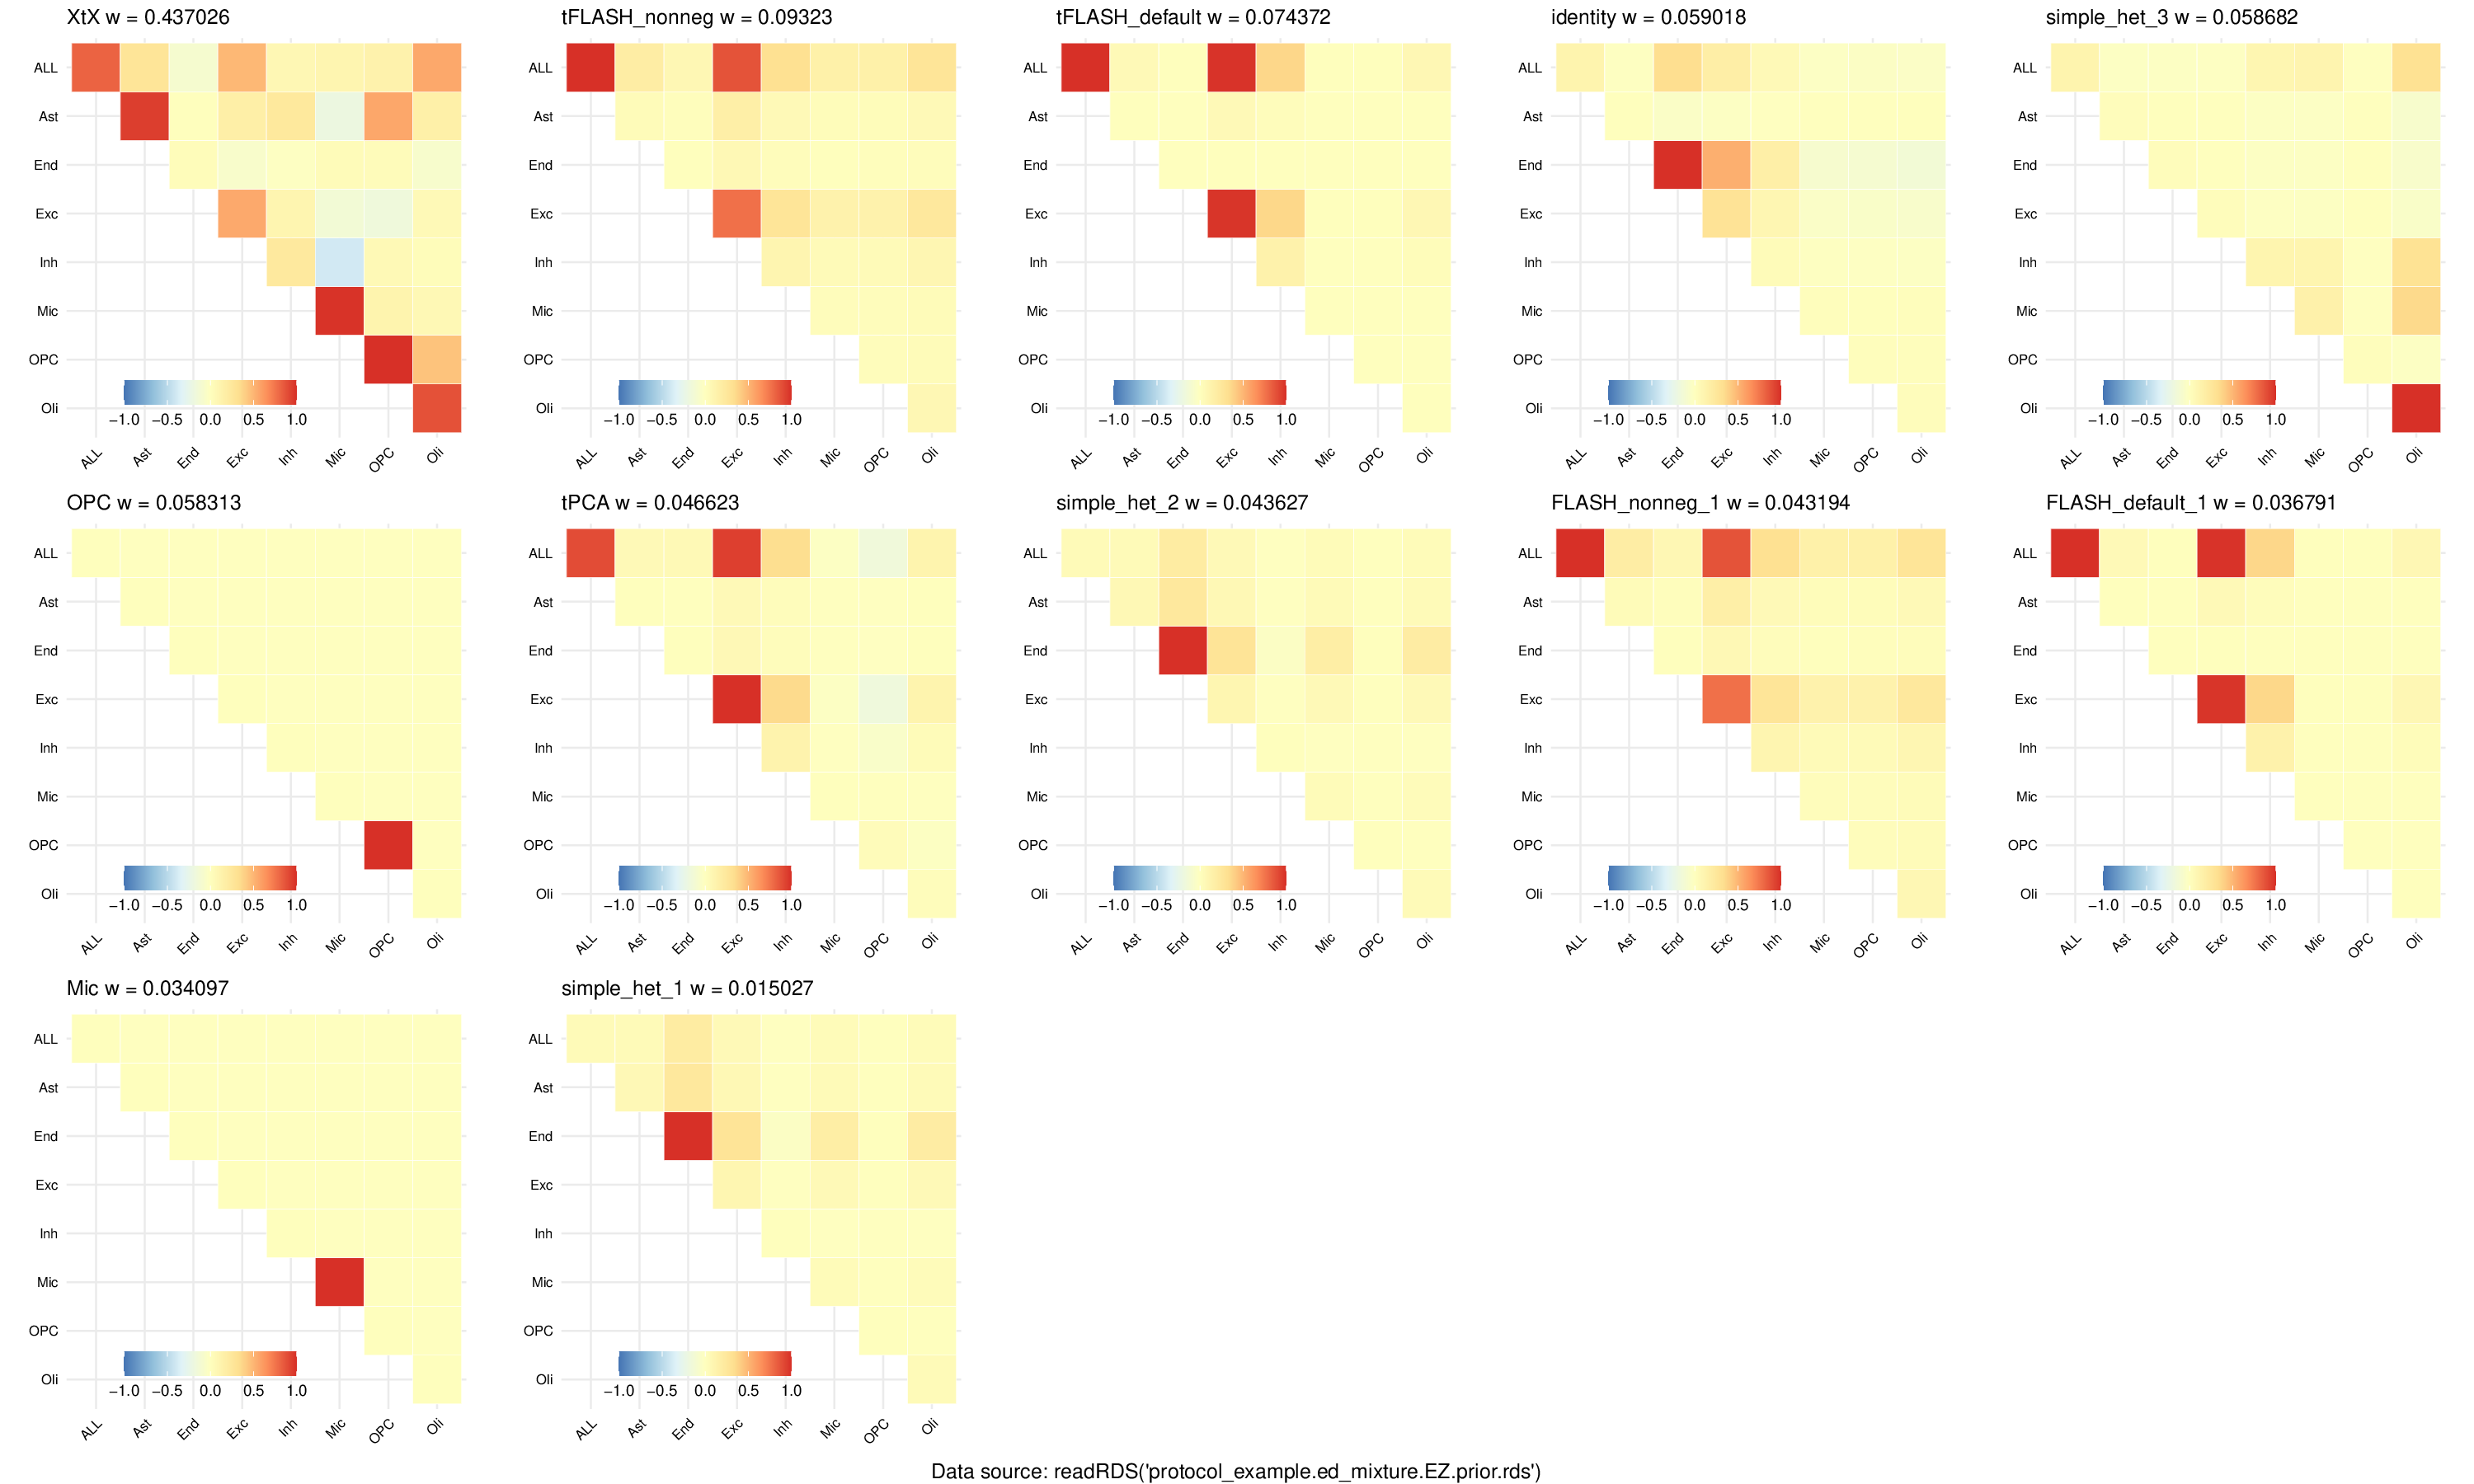

>>> output/mashr/protocol_example.ed_mixture.EZ.prior.pdf:

bash: output/mashr/protocol_example.ed_mixture.EZ.prior.pdf: Permission denied


In [11]:
%preview -n -s png output/mashr/protocol_example.ed_mixture.EZ.prior.pdf

## Global parameters

In [2]:
[global]
parameter: cwd = path('./mashr_workflow_output')
# Input summary statistics data
parameter: data = path
# Prefix of output files. If not specified, it will derive it from data.
# If it is specified, for example, `--output-prefix AnalysisResults`
# It will save output files as `{cwd}/AnalysisResults*`.
parameter: output_prefix = ''
parameter: output_suffix = 'all'
# Exchangable effect (EE) or exchangable z-scores (EZ)
parameter: effect_model = 'EZ'
# Identifier of $\hat{V}$ estimate file
# Options are "identity", "simple", "mle", "vhat_corshrink_xcondition", "vhat_simple_specific"
parameter: vhat = 'simple'
parameter: mixture_components = ['flash', 'flash_nonneg', 'pca',"canonical"]
parameter: container = ""
import re
parameter: entrypoint= ('micromamba run -a "" -n' + ' ' + re.sub(r'(_apptainer:latest|_docker:latest|\.sif)$', '', container.split('/')[-1])) if container else ""
data = data.absolute()
cwd = cwd.absolute()
if len(output_prefix) == 0:
    output_prefix = f"{data:bn}"
prior_data = file_target(f"{cwd:a}/{output_prefix}.{effect_model}.prior.rds")
vhat_data = file_target(f"{cwd:a}/{output_prefix}.{effect_model}.V_{vhat}.rds")

def sort_uniq(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]

## Factor analyses

In [ ]:
# Perform FLASH analysis with non-negative factor constraint
[flash]
input: data
output: f"{cwd}/{output_prefix}.flash.rds"
task: trunk_workers = 1, walltime = '2h', trunk_size = 1, mem = '8G', cores = 2, tags = f'{_output:bn}'
R: expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint=entrypoint
    dat = readRDS(${_input:r})
    dat = mashr::mash_set_data(dat$strong.b, Shat=dat$strong.s, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    res = mashr::cov_flash(dat, factors="default", remove_singleton=${"TRUE" if "canonical" in mixture_components else "FALSE"}, output_model="${_output:n}.model.rds")
    saveRDS(res, ${_output:r})

In [ ]:
# Perform FLASH analysis with non-negative factor constraint
[flash_nonneg]
input: data
output: f"{cwd}/{output_prefix}.flash_nonneg.rds"
task: trunk_workers = 1, walltime = '2h', trunk_size = 1, mem = '8G', cores = 2, tags = f'{_output:bn}'
R: expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint=entrypoint
    dat = readRDS(${_input:r})
    dat = mashr::mash_set_data(dat$strong.b, Shat=dat$strong.s, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    res = mashr::cov_flash(dat, factors="nonneg", remove_singleton=${"TRUE" if "canonical" in mixture_components else "FALSE"}, output_model="${_output:n}.model.rds")
    saveRDS(res, ${_output:r})

In [ ]:
[pca]
# Number of components in PCA analysis for prior
# set to 3 as in mash paper
parameter: npc = 2
input: data
output: f"{cwd}/{output_prefix}.pca.rds"
task: trunk_workers = 1, walltime = '1h', trunk_size = 1, mem = '4G', cores = 2, tags = f'{_output:bn}'
R: expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint=entrypoint
    dat = readRDS(${_input:r})
    dat = mashr::mash_set_data(dat$strong.b, Shat=dat$strong.s, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    res = mashr::cov_pca(dat, ${npc})
    saveRDS(res, ${_output:r})

In [ ]:
[canonical]
input: data
output: f"{cwd}/{output_prefix}.canonical.rds"
task: trunk_workers = 1, walltime = '1h', trunk_size = 1, mem = '4G', cores = 2, tags = f'{_output:bn}'
R: expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint=entrypoint
    library("mashr")
    dat = readRDS(${_input:r})
    dat = mashr::mash_set_data(dat$strong.b, Shat=dat$strong.s, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    res = mashr::cov_canonical(dat)
    saveRDS(res, ${_output:r})

### Estimate residual variance


In [6]:
# V estimate: "identity" method
[vhat_identity]
input: data
output: f'{vhat_data:nn}.V_identity.rds'
task: trunk_workers = 1, walltime = '2h', trunk_size = 1, mem = '8G', cores = 2, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    dat = readRDS(${_input:r})
    saveRDS(diag(ncol(dat$random.b)), ${_output:r})

In [7]:
# V estimate: "simple" method (using null z-scores)
[vhat_simple]
input: data
output: f'{vhat_data:nn}.V_simple.rds'
task: trunk_workers = 1, walltime = '2h', trunk_size = 1, mem = '8G', cores = 2, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    library(mashr)
    dat = readRDS(${_input:r})
    vhat = estimate_null_correlation_simple(mash_set_data(dat$random.b, Shat=dat$random.s, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3))
    saveRDS(vhat, ${_output:r})

In [8]:
# V estimate: "mle" method
[vhat_mle]
# number of samples to use
parameter: n_subset = 6000
# maximum number of iterations
parameter: max_iter = 6

input: data, prior_data
output: f'{vhat_data:nn}.V_mle.rds'
task: trunk_workers = 1, walltime = '36h', trunk_size = 1, mem = '4G', cores = 1, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    library(mashr)
    dat = readRDS(${_input[0]:r})
    # choose random subset
    set.seed(1)
    random.subset = sample(1:nrow(dat$random.b), min(${n_subset}, nrow(dat$random.b)))
    random.subset = mash_set_data(dat$random.b[random.subset,], dat$random.s[random.subset,], alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    # estimate V mle
    vhatprior = mash_estimate_corr_em(random.subset, readRDS(${_input[1]:r})$U, max_iter = ${max_iter})
    vhat = vhatprior$V
    saveRDS(vhat, ${_output:r})

In [ ]:
# Estimate each V separately via corshrink
[vhat_corshrink_xcondition_1]
# Utility script
parameter: util_script = path('/project/mstephens/gtex/scripts/SumstatQuery.R')
# List of genes to analyze
parameter: gene_list = path()

fail_if(not gene_list.is_file(), msg = 'Please specify valid path for --gene-list')
fail_if(not util_script.is_file() and len(str(util_script)), msg = 'Please specify valid path for --util-script')
genes = sort_uniq([x.strip().strip('"') for x in open(f'{gene_list:a}').readlines() if not x.strip().startswith('#')])


depends: R_library("CorShrink")
input: data, for_each = 'genes'
output: f'{vhat_data:nn}/{vhat_data:bnn}_V_corshrink_{_genes}.rds'
task: trunk_workers = 1, walltime = '3m', trunk_size = 500, mem = '3G', cores = 1, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    source(${util_script:r})
    CorShrink_sum = function(gene, database, z_thresh = 2){
      print(gene)
      dat <- GetSS(gene, database)
      z = dat$"z-score"
      max_absz = apply(abs(z), 1, max)
      nullish = which(max_absz < z_thresh)
      # if (length(nullish) < ncol(z)) {
        # stop("not enough null data to estimate null correlation")
      # }
      if (length(nullish) <= 1){
        mat = diag(ncol(z))
      } else {
        nullish_z = z[nullish, ]  
        mat = as.matrix(CorShrink::CorShrinkData(nullish_z, ash.control = list(mixcompdist = "halfuniform"))$cor)
      }
      return(mat)
    }
    V = Corshrink_sum("${_genes}", ${data:r})
    saveRDS(V, ${_output:r})

In [ ]:
# Estimate each V separately via "simple" method
[vhat_simple_specific_1]
# Utility script
parameter: util_script = path('/project/mstephens/gtex/scripts/SumstatQuery.R')
# List of genes to analyze
parameter: gene_list = path()

fail_if(not gene_list.is_file(), msg = 'Please specify valid path for --gene-list')
fail_if(not util_script.is_file() and len(str(util_script)), msg = 'Please specify valid path for --util-script')
genes = sort_uniq([x.strip().strip('"') for x in open(f'{gene_list:a}').readlines() if not x.strip().startswith('#')])

depends: R_library("Matrix")
input: data, for_each = 'genes'
output: f'{vhat_data:nn}/{vhat_data:bnn}_V_simple_{_genes}.rds'

task: trunk_workers = 1, walltime = '1m', trunk_size = 500, mem = '3G', cores = 1, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    source(${util_script:r})
    simple_V = function(gene, database, z_thresh = 2){
      print(gene)
      dat <- GetSS(gene, database)
      z = dat$"z-score"
      max_absz = apply(abs(z), 1, max)
      nullish = which(max_absz < z_thresh)
      # if (length(nullish) < ncol(z)) {
        # stop("not enough null data to estimate null correlation")
      # }
      if (length(nullish) <= 1){
        mat = diag(ncol(z))
      } else {
        nullish_z = z[nullish, ]
        mat = as.matrix(Matrix::nearPD(as.matrix(cov(nullish_z)), conv.tol=1e-06, doSym = TRUE, corr=TRUE)$mat)
      }
      return(mat)
    }
    V = simple_V("${_genes}", ${data:r})
    saveRDS(V, ${_output:r})

In [ ]:
# Consolidate Vhat into one file
[vhat_corshrink_xcondition_2, vhat_simple_specific_2]
depends: R_library("parallel")
# List of genes to analyze
parameter: gene_list = path()

fail_if(not gene_list.is_file(), msg = 'Please specify valid path for --gene-list')
genes = paths([x.strip().strip('"') for x in open(f'{gene_list:a}').readlines() if not x.strip().startswith('#')])


input: group_by = 'all'
output: f"{vhat_data:nn}.V_{step_name.rsplit('_',1)[0]}.rds"

task: trunk_workers = 1, walltime = '1h', trunk_size = 1, mem = '4G', cores = 1, tags = f'{_output:bn}'
R: expand = "${ }", workdir = cwd, stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    library(parallel)
    files = sapply(c(${genes:r,}), function(g) paste0(c(${_input[0]:adr}), '/', g, '.rds'), USE.NAMES=FALSE)
    V = mclapply(files, function(i){ readRDS(i) }, mc.cores = 1)
    R = dim(V[[1]])[1]
    L = length(V)
    V.array = array(as.numeric(unlist(V)), dim=c(R, R, L))
    saveRDS(V.array, ${_output:ar})

### Compute MASH priors 

Main reference are our `mashr` vignettes [this for mashr eQTL outline](https://stephenslab.github.io/mashr/articles/eQTL_outline.html) and [this for using FLASH prior](https://github.com/stephenslab/mashr/blob/master/vignettes/flash_mash.Rmd). 

The outcome of this workflow should be found under `./mashr_flashr_workflow_output` folder (can be configured). File names have pattern `*.mash_model_*.rds`. They can be used to computer posterior for input list of gene-SNP pairs (see next section).

In [ ]:
# Latest update: May/2023
[ud]
# Options are "ted", "ed", 
parameter: unconstrained_prior = "ted"
input:[data, vhat_data if vhat != "mle" else f'{vhat_data:nn}.V_simple.rds'] 
output: prior_data
task: trunk_workers = 1, walltime = '36h', trunk_size = 1, mem = '10G', cores = 4, tags = f'{_output:bn}'
R: expand = "${ }", stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    library(stringr)
    library(udr)
    library(mashr)

    rds_files = c(${_input:r,})
    # mash data 
    dat = readRDS(rds_files[1])
    vhat = readRDS(rds_files[2])

    # Fit mixture model using udr package
    mash_data = mash_set_data(dat$strong.b, Shat=dat$strong.s, V=vhat, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    # Canonical matrices
    U.can = cov_canonical(mash_data)    

    set.seed(999)
    # Penalty strength
    lambda = ncol(dat$strong.z)
    # Initialize udr
    fit0 <- ud_init(mash_data, n_unconstrained = 50)
    # Fit udr and use penalty as default as suggested by Yunqi
    # penalty is necessary in small sample size case, and there won't be a difference in large sample size 
    fit2 = ud_fit(fit0, control = list(unconstrained.update = "${unconstrained_prior}", scaled.update = "fa", resid.update = 'none', 
                                   lambda =lambda, penalty.type = "iw", maxiter=2e3, tol = 1e-2, tol.lik = 1e-2), verbose=TRUE)
    # extract data-driven covariance from udr model. (A list of covariance matrices)
    U.ud <- lapply(fit2$U,function (e) "[["(e,"mat")) 

    saveRDS(list(U=c(U.ud, U.can), w=fit2$w, loglik=fit2$loglik), ${_output:r})

In [ ]:
[ted]
# Method is `ed` or `ted`
parameter: ud_method = "ed"
# A typical choice is to estimate scales only for canonical components
parameter: scale_only = []
# Tolerance for change in likelihood
parameter: ud_tol_lik = 1e-3
input: [data, vhat_data if vhat != "mle" else f'{vhat_data:nn}.V_simple.rds'] + [f"{cwd}/{output_prefix}.{m}.rds" for m in mixture_components]
output: prior_data
task: trunk_workers = 1, walltime = '36h', trunk_size = 1, mem = '10G', cores = 4, tags = f'{_output:bn}'
R: expand = "${ }", stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    library(stringr)
    rds_files = c(${_input:r,})
    dat = readRDS(rds_files[1])
    vhat = readRDS(rds_files[2])
    mash_data = mash_set_data(dat$strong.b, Shat=dat$strong.s, V=vhat, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    # U is different from mashr pipeline, here I kept the later one
    # U = list(XtX = dat$XtX)
    U = list(XtX = t(mash_data$Bhat) %*% mash_data$Bhat / nrow(mash_data$Bhat))

    U_scaled = list()
    mixture_components =  c(${paths(mixture_components):r,})
    scale_only =  c(${paths(scale_only):r,})
    scale_idx = which(mixture_components %in% scale_only )
    for (f in 3:length(rds_files) ) {
        if ((f - 1) %in% scale_idx ) {
          U_scaled = c(U_scaled, readRDS(rds_files[f]))
        } else {
          U = c(U, readRDS(rds_files[f]))
        }
    }
    
    # Fit mixture model using udr package
    library(udr)
    message(paste("Running ${ud_method.upper()} via udr package for", length(U), "mixture components"))
    f0 = ud_init(X = as.matrix(dat$strong.z), V = V, U_scaled = U_scaled, U_unconstrained = U, n_rank1=0)
    res = ud_fit(f0, X = na.omit(f0$X), control = list(unconstrained.update = "ed", resid.update = 'none', scaled.update = "fa", maxiter=5000, tol.lik = ${ud_tol_lik}), verbose=TRUE)
    res_ted =  ud_fit(f0, X = na.omit(f0$X), control = list(unconstrained.update = "ted ", resid.update = 'none', scaled.update = "fa", maxiter=5000, tol.lik = ${ud_tol_lik}), verbose=TRUE)

    saveRDS(list(U=res$U, w=res$w, loglik=res$loglik), ${_output:r})

In [ ]:
[ed_bovy]
parameter: ed_tol = 1e-6
input: [data, vhat_data if vhat != "mle" else f'{vhat_data:nn}.V_simple.rds'] + [f"{cwd}/{output_prefix}.{m}.rds" for m in mixture_components]
output: prior_data
task: trunk_workers = 1, walltime = '36h', trunk_size = 1, mem = '40G', cores = 4, tags = f'{_output:bn}'
R: expand = "${ }", stderr = f"{_output:n}.stderr", stdout = f"{_output:n}.stdout", container = container, entrypoint=entrypoint
    library(mashr)
    rds_files = c(${_input:r,})
    dat = readRDS(rds_files[1])
    vhat = readRDS(rds_files[2])
    mash_data = mash_set_data(dat$strong.b, Shat=dat$strong.s, V=vhat, alpha=${1 if effect_model == 'EZ' else 0}, zero_Bhat_Shat_reset = 1E3)
    # U is different from mashr pipeline, here I kept the later one
    # U = list(XtX = dat$XtX)
    U = list(XtX = t(mash_data$Bhat) %*% mash_data$Bhat / nrow(mash_data$Bhat))
    
    for (f in rds_files[3:length(rds_files)]) U = c(U, readRDS(f))
    # Fit mixture model using ED code by J. Bovy
    message(paste("Running ED via J. Bovy's code for", length(U), "mixture components"))
    res = mashr:::bovy_wrapper(mash_data, U, logfile=${_output:nr}, tol = ${ed_tol})
    saveRDS(list(U=res$Ulist, w=res$pi, loglik=scan("${_output:n}_loglike.log")), ${_output:r})

## Plot patterns of sharing

This is a simple utility function that takes the output from the pipeline above and make some heatmap to show major patterns of multivariate effects. The plots will be ordered by their mixture weights.

In [ ]:
[plot_U]
parameter: model_data = path
# number of components to show
parameter: max_comp = -1
# whether or not to convert to correlation
parameter: to_cor = False
parameter: tol = "1E-6"
parameter: remove_label = False
parameter: name = ""
input: model_data
output: f'{cwd:a}/{_input:bn}{("_" + name.replace("$", "_")) if name != "" else ""}.pdf'
R: expand = "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout', container = container, entrypoint=entrypoint
    library(reshape2)
    library(ggplot2)
    plot_sharing = function(X, col = 'black', to_cor=FALSE, title="", remove_names=F) {
        clrs <- colorRampPalette(rev(c("#D73027","#FC8D59","#FEE090","#FFFFBF",
            "#E0F3F8","#91BFDB","#4575B4")))(128)
        if (to_cor) lat <- cov2cor(X)
        else lat = X/max(diag(X))
        lat[lower.tri(lat)] <- NA
        n <- nrow(lat)
        if (remove_names) {
            colnames(lat) = paste('t',1:n, sep = '')
            rownames(lat) = paste('t',1:n, sep = '')
        }
        melted_cormat <- melt(lat[n:1,], na.rm = TRUE)
        p = ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
            geom_tile(color = "white")+ggtitle(title) + 
            scale_fill_gradientn(colors = clrs, limit = c(-1,1), space = "Lab") +
            theme_minimal()+ 
            coord_fixed() +
            theme(axis.title.x = element_blank(),
                  axis.title.y = element_blank(),
                  axis.text.x = element_text(color=col, size=8,angle=45,hjust=1),
                  axis.text.y = element_text(color=rev(col), size=8),
                  title =element_text(size=10),
                  # panel.grid.major = element_blank(),
                  panel.border = element_blank(),
                  panel.background = element_blank(),
                  axis.ticks = element_blank(),
                  legend.justification = c(1, 0),
                  legend.position = c(0.6, 0),
                  legend.direction = "horizontal")+
            guides(fill = guide_colorbar(title="", barwidth = 7, barheight = 1,
                   title.position = "top", title.hjust = 0.5))
        if(remove_names){
            p = p + scale_x_discrete(labels= 1:n) + scale_y_discrete(labels= n:1)
        }
        return(p)
    }
  
    dat = readRDS(${_input:r})
    name = "${name}"
    if (name != "") {
      if (is.null(dat[[name]])) stop("Cannot find data ${name} in ${_input}")
        dat = dat[[name]]
    }
    if (is.null(names(dat$U))) names(dat$U) = paste0("Comp_", 1:length(dat$U))
    meta = data.frame(names(dat$U), dat$w, stringsAsFactors=F)
    colnames(meta) = c("U", "w")
    tol = ${tol}
    n_comp = length(meta$U[which(meta$w>tol)])
    meta = head(meta[order(meta[,2], decreasing = T),], ${max_comp if max_comp > 1 else "nrow(meta)"})
    message(paste(n_comp, "components out of", length(dat$w), "total components have weight greater than", tol))
    res = list()
    for (i in 1:n_comp) {
        title = paste(meta$U[i], "w =", round(meta$w[i], 6))
        ##Handle updated udr data structure
        if(is.list(dat$U[[meta$U[i]]])){
          res[[i]] = plot_sharing(dat$U[[meta$U[i]]]$mat, to_cor = ${"T" if to_cor else "F"}, title=title, remove_names = ${"TRUE" if remove_label else "FALSE"})
        } else if(is.matrix(dat$U[[meta$U[i]]])){
          res[[i]] = plot_sharing(dat$U[[meta$U[i]]], to_cor = ${"T" if to_cor else "F"}, title=title, remove_names = ${"TRUE" if remove_label else "FALSE"})
        }
    }
    unit = 4
    n_col = 5
    n_row = ceiling(n_comp / n_col)
    pdf(${_output:r}, width = unit * n_col, height = unit * n_row)
    do.call(gridExtra::grid.arrange, c(res, list(ncol = n_col, nrow = n_row, bottom = "Data source: readRDS(${_input:br})${('$'+name) if name else ''}")))
    dev.off()